In [31]:
import os, shutil, pathlib
original_dir = pathlib.Path("../../../local/dogs_vs_cats/train/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [32]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname, dst=dir/fname)


In [33]:
make_subset("train", start_index=0, end_index=1000)

In [34]:
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [35]:
import keras
from keras import layers

inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer="he_uniform")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer="he_uniform")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer="he_uniform")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer="he_uniform")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer="he_uniform")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid", kernel_initializer="glorot_uniform")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [36]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir/ "train",
    image_size = (180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [38]:
for data_batch, labels_batch in train_dataset:
    print(data_batch.shape, labels_batch.shape)
    break


(32, 180, 180, 3) (32,)


In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [40]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [41]:
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5450 - loss: 0.9387 - val_accuracy: 0.5590 - val_loss: 0.6761
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6265 - loss: 0.7018 - val_accuracy: 0.6340 - val_loss: 0.6315
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6640 - loss: 0.6091 - val_accuracy: 0.6700 - val_loss: 0.6087
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7170 - loss: 0.5569 - val_accuracy: 0.6950 - val_loss: 0.5798
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7470 - loss: 0.5087 - val_accuracy: 0.6960 - val_loss: 0.5865
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8005 - loss: 0.4390 - val_accuracy: 0.7230 - val_loss: 0.5743
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8390 - loss: 0.3703 - val_accuracy: 0.7100 - val_loss: 0.6226
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8625 - loss: 0.3099 - val_accuracy: 0.7250 - v

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["accuracy", "val_accuracy"]].plot(ax = ax[1], title = "Accuracy", grid = True)

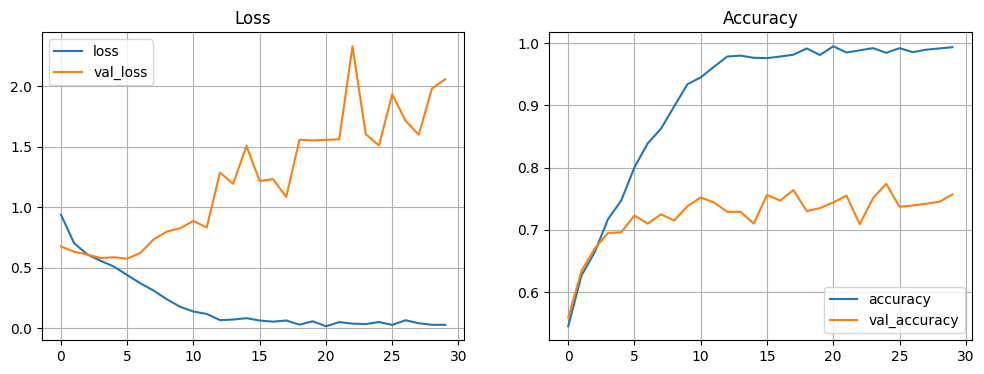

In [43]:

plot_metrics(pd.DataFrame(history.history))

#### Utan he-init (glorot)
<img src="loss_defaults.png">

In [44]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7070 - loss: 0.5886
Test accuracy: 0.707


In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

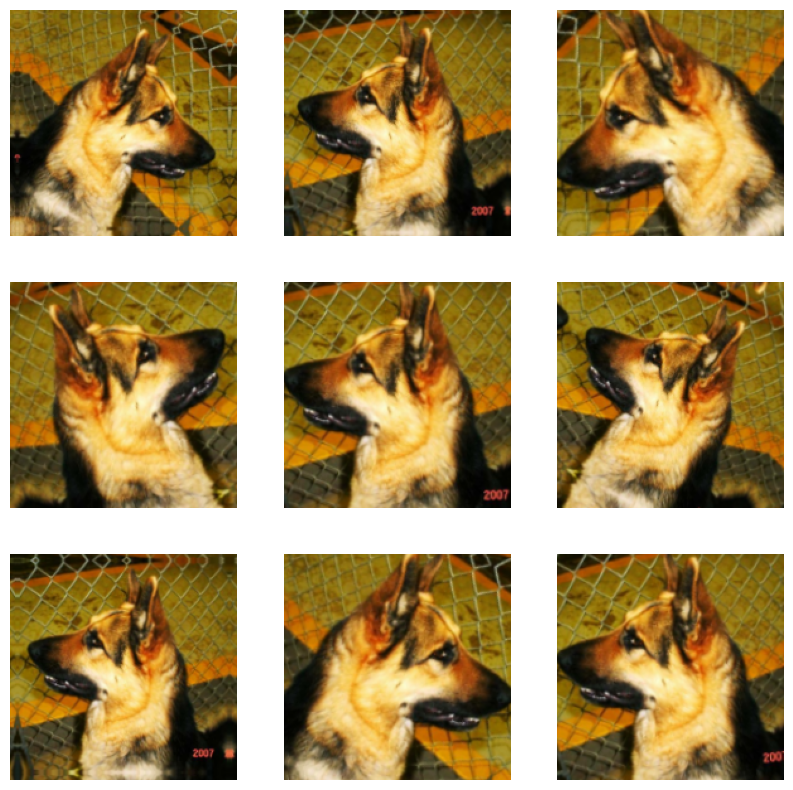

In [46]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [47]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop",loss="binary_crossentropy", metrics=["accuracy"])

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [49]:
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4905 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5330 - loss: 0.6950 - val_accuracy: 0.5320 - val_loss: 0.6882
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5390 - loss: 0.6913 - val_accuracy: 0.5010 - val_loss: 0.6959
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5820 - loss: 0.6783 - val_accuracy: 0.5480 - val_loss: 0.6707
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6185 - loss: 0.6649 - val_accuracy: 0.5410 - val_loss: 0.7259
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6270 - loss: 0.6410 - val_accuracy: 0.6530 - val_loss: 0.6104
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6665 - loss: 0.6156 - val_accuracy: 0.6570 - val_loss: 0.6182
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6790 - loss: 0.6078 - val_accuracy: 0.6810 - v

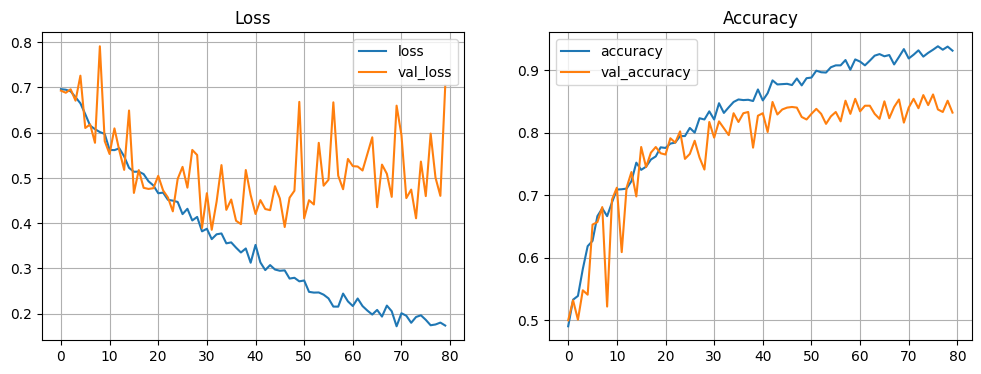

In [50]:
plot_metrics(pd.DataFrame(history.history))

In [51]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(test_loss, test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8110 - loss: 0.4373
0.4373072385787964 0.8109999895095825


In [52]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180,180,3)
)

In [53]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [55]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

2025-12-07 14:23:21.350708: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [57]:
history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9275 - loss: 10.1707 - val_accuracy: 0.9670 - val_loss: 4.5691
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9680 - loss: 5.6244 - val_accuracy: 0.9740 - val_loss: 4.4561
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 2.5726 - val_accuracy: 0.9750 - val_loss: 4.4462
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.8466 - val_accuracy: 0.9600 - val_loss: 10.3591
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9895 - loss: 1.4953 - val_accuracy: 0.9730 - val_loss: 4.3107
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.9091 - val_accuracy: 0.9710 - val_loss: 7.0902
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.3662 - val_accuracy: 0.9630 - val_loss: 10.2784
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.2965 - val_accuracy: 0.9740 - val_l

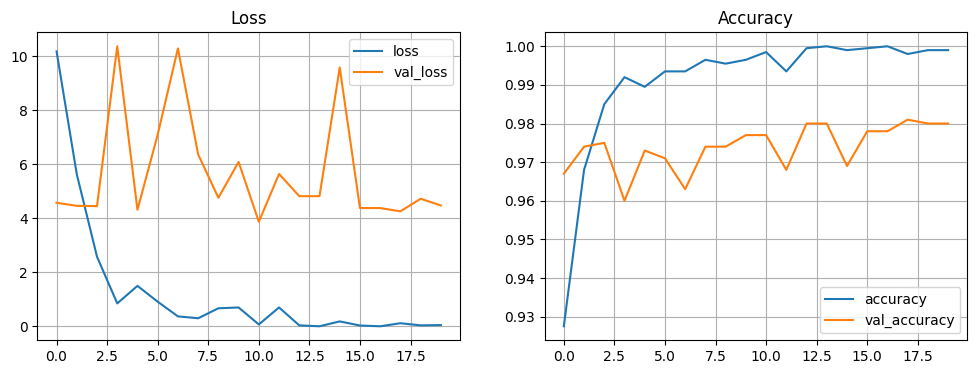

In [58]:
plot_metrics(pd.DataFrame(history.history))

In [59]:
test_model = keras.models.load_model("feature_extraction.keras")

test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(test_loss, test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9700 - loss: 6.9268  
6.926791191101074 0.9700000286102295
